# Notebook initialization

Run this cell to create all helper files and download data


In [57]:
%pip install -U pandas numpy matplotlib seaborn requests scikit-learn tqdm pyarrow yfinance lightgbm --break-system-packages

Note: you may need to restart the kernel to use updated packages.


In [58]:
%%writefile data_processing.py
"""
data_processing.py

Utility functions for:
- Loading and processing Fed-related CSV files into a single ML-ready DataFrame
- Optionally downloading Fed CSV files from GitHub into ./data/fed_csv
- Loading and processing S&P 500 OHLCV data

This module is generated dynamically inside the notebook
to comply with the "no external .py files" requirement.
"""

import os
import glob
import re
from pathlib import Path

import pandas as pd
import numpy as np
import requests
import yfinance as yf

# ---------------------------------------------------------------------
# Config
# ---------------------------------------------------------------------

# Local directory where Fed CSV files are stored
DATA_DIR = "data/fed_csv"

# GitHub repo configuration (optional, for reproducibility)
REPO_OWNER = "MichaelCarloH"
REPO_NAME = "ML-PortfolioManagement"
FOLDER_PATH = "data/fed_csv"  # path inside the repo (no leading/trailing slash)


# ---------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------

def _log(msg: str, verbose: bool) -> None:
    if verbose:
        print(msg)


def ensure_data_dir(path: str = DATA_DIR) -> None:
    """
    Ensure that the local data directory exists.
    """
    os.makedirs(path, exist_ok=True)


def fetch_csv_from_github_folder(
    repo_owner: str = REPO_OWNER,
    repo_name: str = REPO_NAME,
    folder_path: str = FOLDER_PATH,
    local_dir: str = DATA_DIR,
    verbose: bool = False,
) -> bool:
    """
    Try to fetch all .csv files from a GitHub folder via the GitHub API
    and save them into `local_dir`.

    Returns
    -------
    bool
        True if at least one CSV was downloaded, False otherwise.
    """
    ensure_data_dir(local_dir)

    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}"
    response = requests.get(api_url)

    if response.status_code != 200:
        _log(
            f"[INFO] Could not access GitHub folder ({response.status_code}). "
            "Proceeding without remote download.",
            verbose,
        )
        return False

    items = response.json()
    csv_files = [item for item in items if item["name"].endswith(".csv")]

    if not csv_files:
        _log("[INFO] No CSV files found in the specified GitHub folder.", verbose)
        return False

    downloaded_any = False
    for item in csv_files:
        download_url = item["download_url"]
        filename = item["name"]
        local_path = os.path.join(local_dir, filename)

        file_response = requests.get(download_url)
        if file_response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(file_response.content)
            downloaded_any = True
            _log(f"Downloaded: {filename}", verbose)
        else:
            _log(
                f"[WARN] Failed to download {filename}: {file_response.status_code}",
                verbose,
            )

    return downloaded_any


# ---------------------------------------------------------------------
# Fed CSV processing
# ---------------------------------------------------------------------

def load_all_csvs(
    local_dir: str = DATA_DIR,
    pattern: str = "*.csv",
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Load, merge, and process all Fed CSVs into an ML-ready, forward-filled dataframe.

    Steps:
    - Reads all CSVs in `local_dir` matching `pattern`.
    - Extracts date and outcome columns.
    - Merges all files into one unified dataframe.
    - Converts to ML-wide format with clean feature names.
    - Saves:
        - data/fed_events_merged.csv
        - data/fed_events_ml_ready.csv
        - data/fed_events_ml_ready_ffill.csv
    - Returns:
        - Forward-filled ML-ready DataFrame (fed_events_ml_ready_ffill.csv).
    """

    def log(msg: str):
        if verbose:
            print(msg)

    ensure_data_dir(local_dir)

    # --- Step 1: find CSV files ---
    fed_csv_path = Path(local_dir)
    csv_files = list(fed_csv_path.glob(pattern))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {fed_csv_path} matching {pattern}")
    log(f"Found {len(csv_files)} CSV files")

    # --- Step 2: process each file ---
    all_dataframes = []
    for csv_file in csv_files:
        title = csv_file.stem
        log(f"Processing: {title}")

        try:
            df = pd.read_csv(csv_file)

            # Identify date column
            date_col = next(
                (c for c in df.columns if "date" in c.lower() and "utc" in c.lower()),
                None,
            )
            if date_col is None:
                log(f"  ⚠ No date column found, skipping {title}")
                continue

            # Identify outcome columns
            outcome_cols = [
                c for c in df.columns
                if c != date_col and "timestamp" not in c.lower()
            ]
            if not outcome_cols:
                log(f"  ⚠ No outcome columns found, skipping {title}")
                continue

            # Convert data types
            df[date_col] = pd.to_datetime(
                df[date_col],
                format="%m-%d-%Y %H:%M",
                errors="coerce",
            )
            for c in outcome_cols:
                df[c] = pd.to_numeric(df[c], errors="coerce")

            # Merge same-date rows: first non-null per column
            merged_df = df.groupby(date_col).agg({
                c: (lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else None)
                for c in outcome_cols
            }).reset_index()

            merged_df["Title"] = title
            merged_df = merged_df.rename(columns={date_col: "Date"})
            merged_df = merged_df[["Date", "Title"] + outcome_cols]
            all_dataframes.append(merged_df)
            log(f"  ✓ {len(merged_df)} unique dates")

        except Exception as e:
            log(f"  ✗ Error processing {title}: {e}")

    if not all_dataframes:
        raise RuntimeError("No valid CSVs processed.")

    # --- Step 3: merge all dataframes ---
    log("Merging all dataframes...")
    all_outcome_cols = sorted(list({
        c
        for df in all_dataframes
        for c in df.columns
        if c not in ["Date", "Title"]
    }))

    final_dfs = []
    for df in all_dataframes:
        for c in all_outcome_cols:
            if c not in df.columns:
                df[c] = None
        final_dfs.append(df[["Date", "Title"] + all_outcome_cols])

    final_df = (
        pd.concat(final_dfs, ignore_index=True)
        .sort_values(["Date", "Title"])
        .reset_index(drop=True)
    )

    os.makedirs("data", exist_ok=True)
    merged_path = Path("data/fed_events_merged.csv")
    final_df.to_csv(merged_path, index=False)
    log(f"Saved merged dataframe to: {merged_path}")

    # --- Step 4: long format ---
    id_vars = ["Date", "Title"]
    value_cols = [c for c in final_df.columns if c not in id_vars]

    df_long = pd.melt(
        final_df,
        id_vars=id_vars,
        value_vars=value_cols,
        var_name="Outcome",
        value_name="Probability",
    ).dropna(subset=["Probability"])

    # --- Step 5: clean feature names ---
    def sanitize_feature_name(title: str, outcome: str) -> str:
        feature = f"{title}_{outcome}"
        feature = re.sub(r"[^a-zA-Z0-9_\s]", "", feature)
        feature = re.sub(r"\s+", "_", feature)
        feature = re.sub(r"_+", "_", feature).strip("_")
        return feature

    df_long["Feature"] = df_long.apply(
        lambda r: sanitize_feature_name(r["Title"], r["Outcome"]),
        axis=1,
    )

    # --- Step 6: pivot to ML-wide ---
    df_ml = df_long.pivot_table(
        index="Date",
        columns="Feature",
        values="Probability",
        aggfunc="first",
    ).reset_index()

    cols = ["Date"] + sorted([c for c in df_ml.columns if c != "Date"])
    df_ml = df_ml[cols]

    ml_ready_path = Path("data/fed_events_ml_ready.csv")
    df_ml.to_csv(ml_ready_path, index=False)
    log(f"Saved ML-ready dataframe to: {ml_ready_path}")

    # --- Step 7: forward-fill version ---
    df_ml_ffill = df_ml.sort_values("Date").copy()
    df_ml_ffill.iloc[:, 1:] = df_ml_ffill.iloc[:, 1:].ffill().fillna(0)

    ffill_path = Path("data/fed_events_ml_ready_ffill.csv")
    df_ml_ffill.to_csv(ffill_path, index=False)
    log(f"Saved forward-filled dataframe to: {ffill_path}")

    # --- Step 8: summary (optional) ---
    log("=== FED DATA SUMMARY ===")
    log(f"Rows (dates): {len(df_ml_ffill)}")
    log(f"Features: {len(df_ml_ffill.columns) - 1}")
    log(
        f"Date range: {df_ml_ffill['Date'].min()} → {df_ml_ffill['Date'].max()}"
    )

    return df_ml_ffill


def get_fed_data(verbose: bool = False) -> pd.DataFrame:
    """
    High-level convenience function for the notebook.

    - Tries to load processed data from local ./data/fed_csv.
    - If no raw CSVs exist, optionally tries to download them from GitHub.
    - Returns the final forward-filled ML-ready dataframe.
    """
    ensure_data_dir(DATA_DIR)

    # 1) Check for existing local CSVs
    csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

    # 2) If none, try GitHub (non-fatal if it fails)
    if not csv_files:
        _log(
            "No local Fed CSV files found in ./data/fed_csv. "
            "Attempting to download from GitHub...",
            verbose,
        )
        ok = fetch_csv_from_github_folder(verbose=verbose)
        if not ok:
            raise FileNotFoundError(
                "No local Fed CSVs and GitHub download failed. "
                "Ensure ./data/fed_csv contains the required files "
                "in the submitted project."
            )

    # 3) Build and return processed dataframe
    return load_all_csvs(local_dir=DATA_DIR, verbose=verbose)


# ---------------------------------------------------------------------
# S&P 500 loader
# ---------------------------------------------------------------------

def load_sp500_data(
    ticker: str = "^GSPC",
    start: str = "2023-01-01",
    end: str = None,
    output_path: str = "data/sp500_ohlcv_returns.csv",
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Download, process, and save S&P 500 OHLCV and derived metrics.

    Returns a dataframe indexed by Date (UTC) with:
    - OHLCV
    - Daily_Return, Log_Return
    - High/Low and Open/Close ranges
    - Volume_MA_20, Volume_Ratio
    - Price_MA_20, Price_MA_50
    - Volatility_20
    """

    def log(msg: str):
        if verbose:
            print(msg)

    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    log(f"Downloading {ticker} from Yahoo Finance...")
    spx = yf.download(
        ticker,
        start=start,
        end=end,
        progress=False,
        auto_adjust=True,
    )

    if spx.empty:
        raise RuntimeError(f"No data returned for {ticker} from Yahoo Finance.")

    # Flatten multi-index columns if present
    if isinstance(spx.columns, pd.MultiIndex):
        spx.columns = spx.columns.get_level_values(0)

    # Metrics
    spx["Daily_Return"] = spx["Close"].pct_change()
    spx["Log_Return"] = np.log(spx["Close"] / spx["Close"].shift(1))
    spx["High_Low_Range"] = (spx["High"] - spx["Low"]) / spx["Close"]
    spx["Open_Close_Range"] = (spx["Open"] - spx["Close"]).abs() / spx["Close"]
    spx["Volume_MA_20"] = spx["Volume"].rolling(20).mean()
    spx["Volume_Ratio"] = spx["Volume"] / spx["Volume_MA_20"]
    spx["Price_MA_20"] = spx["Close"].rolling(20).mean()
    spx["Price_MA_50"] = spx["Close"].rolling(50).mean()
    spx["Volatility_20"] = spx["Daily_Return"].rolling(20).std()

    cols_to_keep = [
        "Open", "High", "Low", "Close", "Volume",
        "Daily_Return", "Log_Return",
        "High_Low_Range", "Open_Close_Range",
        "Volume_MA_20", "Volume_Ratio",
        "Price_MA_20", "Price_MA_50", "Volatility_20",
    ]
    available = [c for c in cols_to_keep if c in spx.columns]

    daily = spx[available].dropna().copy()
    daily.index.name = "Date (UTC)"

    daily.to_csv(output_path)
    log(f"Saved S&P 500 data to: {output_path.resolve()}")

    if verbose:
        log(f"Rows: {len(daily)}")
        log(f"Date range: {daily.index.min()} → {daily.index.max()}")

    return daily


Overwriting data_processing.py


# Guidelines


We outline a structured approach for presenting research findings. The framework is divided into several key segments:

1. Introduction
1. Dataset overview
1. Analytics and learning strategies
1. Empirical resuts: baseline and robustness
1. Conclusion

The opening segment encompasses four essential elements:

- Contextual Background: What is the larger setting of the study? What makes this area of inquiry compelling? What are the existing gaps or limitations within the current body of research? What are some unanswered yet noteworthy questions?

- Project Contributions: What are the specific advancements made by this study, such as in data acquisition, algorithmic development, parameter adjustments, etc.?

- Summary of the main empirical results: What is the main statistical statement? is it significant (e.g. statistically or economically)?

- Literature and Resource Citations: What are related academic papers? What are the github repositories, expert blogs, or software packages that used in this project?

In the dataset profile, one should consider:

- The origin and composition of data utilized in the study. If the dataset is original, then provide the source code to ensure reproducibility.

- The chronological accuracy of the data points, verifying that the dates reflect the actual availability of information.

- A detailed analysis of descriptive statistics, with an emphasis on discussing the importance of the chosen graphs or metrics.

The analytics and machine learning methodologies section accounts for:

- A detailed explanation of the foundational algorithm.

- A description of the data partitioning strategy for training, validation and test.

- An overview of the parameter selection and optimization process.

To effectively convey the empirical findings, separate the baseline results from the additional robustness tests. Within the primary empirical outcomes portion, include:

- Key statistical evaluations (for instance, if presenting a backtest – provide a pnl graph alongside the Sharpe ratio).

- Insights into what primarily influences the results, such as specific characteristics or assets that significantly impact performance.

The robustness of empirical tests section should detail:

- Evaluation of the stability of the principal finding against variations in hyperparameters or algorithmic modifications.

Finally, the conclusive synthesis should recapitulate the primary findings, consider external elements that may influence the results, and hint at potential directions for further investigative work.


# Introduction


In this project of Machine Learning for Portfolio Managment and Trading, we are tasked to loosely investigate the effect of central banks policies on the market. In our proposed approach we look at betting data, specifically on FED decisions and seek to develop a tradable strategy. The data is sourced from Polymarket which is a decentralized prediction market platform that uses blockchain technology to let users bet on the outcomes of real-world events.


## Contextual Background

- **Macro-financial setting:** The project operates at the intersection of monetary-policy expectations and equity-market positioning, focusing on how Federal Open Market Committee (FOMC) decisions ripple through the S&P 500. Polymarket prediction markets provide high-frequency probability updates on rate cuts and leadership scenarios,furthermore they operate perpetually not being restricted to traditional marker hours.
- **Motivation and gaps:** Prior academic and practitioner research documents that option-implied probabilities and macro-news sentiment foreshadow FOMC-day volatility, yet public prediction-market data remains underexplored. Existing studies either rely on proprietary dealer quotes or low-frequency survey data, leaving an opportunity to test whether crowd-sourced probability surfaces encode tradable signals.
- **Open questions:** Key open questions include (i) how quickly prediction-market probabilities anticipate rate moves, (ii) whether the implied probabilities add incremental signal once traditional macro data is controlled for, and (iii) the robustness of any trading edge once transaction costs and alternate market regimes are considered.

## Project Contributions

- **Integrated data acquisition:** Consolidated raw Polymarket CSV exports and manually curated Federal Reserve event datasets into harmonised, analysis-ready tables (e.g., `polymarket_fed_events_and_markets.csv`, `fed_events_ml_ready_ffill.csv`).
- **Feature engineering pipeline:** Produced merged S&P 500 and Polymarket features with forward-filled probability fields, calendar event encodings, and target variables capturing post-announcement returns (`sp500_fed_ml_ready_with_targets.csv`).
- **Model experimentation:** Implemented data loaders (`dataloaders/s&p_loader.py`) and notebooks (`notebooks/fed_probability_prediction.ipynb`) to evaluate supervised models that translate probability movements into trading rules, including Sharpe-ratio oriented strategy evaluations in `rate_cut_strategy_sharpe_analysis.csv` outputs.
- **Backtesting utilities:** Generated out-of-sample trade logs (`notebooks/outputs/trades_oos.csv`) that benchmark polymarket-informed strategies against baseline macro strategies.

## Summary of Empirical Results

- **Performance snapshot:** The `notebooks/outputs/trades_all_strategies.csv` output indicates that probability-driven strategies deliver positive average returns with improved risk-adjusted performance relative to naive benchmarks, as evidenced by Sharpe ratio calculations stored in `data/s&p_data/rate_cut_strategy_sharpe_analysis.csv`.
- **Economic significance:** Strategy evaluations demonstrate economically meaningful improvements in Sharpe ratios when prediction-market features are incorporated, highlighting the potential of crowd-sourced expectations to complement conventional macro indicators.

## Literature and Resource Citations

- **Related research:**
  - Andersen, T. G., Bollerslev, T., Diebold, F. X., & Vega, C. (2007). _Real-Time Price Discovery in Stock, Bond and Foreign Exchange Markets_.
  - Lucca, D. O., & Moench, E. (2015). _The Pre-FOMC Announcement Drift_.
  - Wolfers, J., & Zitzewitz, E. (2006). _Prediction Markets in Theory and Practice_.
- **Software and repositories:**
  - [Polymarket API & CSV exports](https://polymarket.com/)
  - [Pandas](https://pandas.pydata.org/), [scikit-learn](https://scikit-learn.org/), and related Python data-science libraries (dependencies managed via `uv` as specified in `uv.toml`).

## Dataset Profile

- **Source composition:**
  - **Polymarket market histories:** Stored under `data/s&p_data/`, including `polymarket-price-data-24-07-2025-24-10-2025-1761316761596.csv` and the merged `polymarket_fed_events_and_markets.csv` file.
  - **Federal Reserve event catalogues:** CSV files in `data/fed_csv/` and curated aggregations such as `fed_events_merged.csv`, providing policy-meeting metadata and outcome annotations.
  - **Market benchmarks:** S&P 500 price and returns series within `data/s&p_data/sp500_ohlcv_returns.csv` and derived merges (`sp500_fed_merged_ml_ready.csv`).
- **Processing workflow:** The `notebooks/data_exploration.ipynb` notebook surveys raw distributions, while `notebooks/data_processing.ipynb` applies cleaning, forward-filling, and target construction routines. Reproducible processing steps are scripted through reusable loaders in `dataloaders/s&p_loader.py`, ensuring downstream model notebooks operate on consistent feature matrices.
- **Reproducibility notes:** Raw Polymarket CSVs and Fed event files are preserved in the repository. Transformation logic is encapsulated in notebooks and loaders, enabling regeneration of the merged dataset. When extending the dataset, run the processing notebook or invoke the loader module to re-create `sp500_fed_ml_ready_with_targets.csv` from the raw components.


# Data


The data used is Polymarket betting quotes on several Fed related topics, csv data can be downloaded at: https://polymarket.com/search?_q=fed

In this notebook we point to the Github repository where static data obtained at the time of the analysis is located and can be used to reproduce the results of this project


In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from data_processing import get_fed_data

fed_df = get_fed_data()
fed_df.head()

/Users/ryangumsheimer/University/ENSAE/ML-PortfolioManagement/lightgbm_test/data_processing.py:218: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(final_dfs, ignore_index=True)


Feature,Date,Fed_Interest_Rates_November_2024_25_bps_decrease,Fed_Interest_Rates_November_2024_25_bps_increase,Fed_Interest_Rates_November_2024_50_bps_decrease,Fed_Interest_Rates_November_2024_75_bps_decrease,Fed_Interest_Rates_November_2024_No_Change,Fed_Interest_Rates_November_2024_Other,Fed_abolished_in_2025_Price,Fed_decision_in_December_25_bps_decrease,Fed_decision_in_December_25_bps_increase,...,Who_will_Trump_nominate_as_Fed_Chair_Larry_Lindsey,Who_will_Trump_nominate_as_Fed_Chair_Lorie_K_Logan,Who_will_Trump_nominate_as_Fed_Chair_Marc_Sumerlin,Who_will_Trump_nominate_as_Fed_Chair_Michelle_Bowman,Who_will_Trump_nominate_as_Fed_Chair_No_one_nominated_before_2027,Who_will_Trump_nominate_as_Fed_Chair_Philip_Jefferson,Who_will_Trump_nominate_as_Fed_Chair_Rick_Rieder,Who_will_Trump_nominate_as_Fed_Chair_Ron_Paul,Who_will_Trump_nominate_as_Fed_Chair_Scott_Bessent,Who_will_Trump_nominate_as_Fed_Chair_Stephen_Miran
0,2024-08-03,0.315,0.0250,0.270,0.125,0.215,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-08-04,0.370,0.0225,0.265,0.125,0.215,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-08-05,0.355,0.0225,0.275,0.125,0.200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-08-06,0.345,0.0110,0.325,0.110,0.170,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-08-07,0.380,0.0125,0.275,0.105,0.130,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Merging Fed time series with S&P500 time series


In [60]:
from data_processing import load_sp500_data

spx = load_sp500_data(verbose=False)
spx.head()

Price,Open,High,Low,Close,Volume,Daily_Return,Log_Return,High_Low_Range,Open_Close_Range,Volume_MA_20,Volume_Ratio,Price_MA_20,Price_MA_50,Volatility_20
Date (UTC),,,,,,,,,,,,,,
2023-03-15,3876.739990,3894.260010,3838.239990,3891.929932,6594010000,-0.006981,-0.007005,0.014394,0.003903,4.499821e+09,1.465394,3984.615515,4003.584209,0.010362
2023-03-16,3878.929932,3964.459961,3864.110107,3960.280029,5695790000,0.017562,0.017410,0.025339,0.020542,4.580812e+09,1.243402,3975.249512,4006.307012,0.011282
2023-03-17,3958.689941,3958.909912,3901.270020,3916.639893,9354280000,-0.011019,-0.011081,0.014717,0.010736,4.841342e+09,1.932167,3966.561011,4007.580410,0.011149
2023-03-20,3917.469971,3956.620117,3916.889893,3951.570068,5347140000,0.008918,0.008879,0.010054,0.008630,4.906426e+09,1.089824,3960.185010,4010.449810,0.011415
2023-03-21,3975.889893,4009.080078,3971.189941,4002.870117,4920240000,0.012982,0.012899,0.009466,0.006740,4.946358e+09,0.994720,3960.461511,4012.605610,0.010976


In [61]:
# Ensure consistent Date column
if isinstance(spx.index, pd.DatetimeIndex) or spx.index.name:
    spx = spx.reset_index()

if 'Date (UTC)' in spx.columns:
    spx = spx.rename(columns={'Date (UTC)': 'Date'})
elif 'Date' not in spx.columns:
    raise ValueError("spx has no Date/Date (UTC) column")

if 'Date' not in fed_df.columns and isinstance(fed_df.index, pd.DatetimeIndex):
    fed_df = fed_df.reset_index().rename(columns={'index': 'Date'})

spx['Date'] = pd.to_datetime(spx['Date'])
fed_df['Date'] = pd.to_datetime(fed_df['Date'])

start_date = pd.to_datetime(fed_df['Date'].min())

merged_df = (
    pd.merge(spx, fed_df, on='Date', how='left', sort=True)
    .query('Date >= @start_date')
    .sort_values('Date')
    .reset_index(drop=True)
)

merged_df.head()

,Date,Open,High,Low,Close,Volume,Daily_Return,Log_Return,High_Low_Range,Open_Close_Range,...,Who_will_Trump_nominate_as_Fed_Chair_Larry_Lindsey,Who_will_Trump_nominate_as_Fed_Chair_Lorie_K_Logan,Who_will_Trump_nominate_as_Fed_Chair_Marc_Sumerlin,Who_will_Trump_nominate_as_Fed_Chair_Michelle_Bowman,Who_will_Trump_nominate_as_Fed_Chair_No_one_nominated_before_2027,Who_will_Trump_nominate_as_Fed_Chair_Philip_Jefferson,Who_will_Trump_nominate_as_Fed_Chair_Rick_Rieder,Who_will_Trump_nominate_as_Fed_Chair_Ron_Paul,Who_will_Trump_nominate_as_Fed_Chair_Scott_Bessent,Who_will_Trump_nominate_as_Fed_Chair_Stephen_Miran
0,2024-08-05,5151.140137,5250.890137,5119.259766,5186.330078,5333250000,-0.029969,-0.030427,0.025380,0.006785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-08-06,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,0.010354,0.010301,0.022668,0.006414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-08-07,5293.129883,5330.640137,5195.540039,5199.500000,4558260000,-0.007735,-0.007765,0.025983,0.018007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-08-08,5252.569824,5328.029785,5233.850098,5319.310059,4016830000,0.023043,0.022781,0.017705,0.012547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-08-09,5314.660156,5358.669922,5300.839844,5344.160156,3516400000,0.004672,0.004661,0.010821,0.005520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Indicator fo fed market sentiment shift

In this section we aim to develop an indicator which can gain insights from the fed dataset we obtained. The dataset is composed of multiple bets which are vaailable at different times, since polymarket has been growing so has the volume and number of bets vaailable. We look at the variation in probability for all events. Example at one time we might have 25bps decrease in november, december, january and 50 bs decrease etc. Now we ocunt how many deltas were positive at each time instance and we follwo this coint for each time step then we apply moving averages to compare short term change and long term pricing of probabilioties and we develop a trading startegy based on corssing of such moving avergaes


## 4. Fed Market Sentiment Indicator — Construction, Logic & Interpretation

This section introduces a **market-implied sentiment indicator** based on Polymarket probabilities for Federal Reserve interest rate outcomes.  
The goal is to capture shifts in expectations — _how dovish or hawkish the market is becoming_ — and study how these shifts relate to the S&P 500.


### 4.1. Background and Motivation

Polymarket lists multiple prediction markets for each Fed meeting — for example:

- `..._25_bps_decrease`
- `..._50_bps_decrease`
- `..._No_Change`
- `..._25_bps_increase`

Each column represents the **probability** that a given rate outcome will occur.  
As macroeconomic data, speeches, or risk events unfold, these probabilities move — revealing the market’s evolving beliefs about monetary policy.

Our goal is to summarize these changes into one interpretable metric — the **Net BPS Sentiment Indicator** — which measures whether the overall expectation is shifting _dovish_ (toward cuts) or _hawkish_ (toward hikes).

---

### 4.2. Step-by-Step Construction

At each time step \( t \) and for each outcome \( j \):

1. **Compute the change in probability**  
   \[
   \Delta p*{t,j} = p*{t,j} - p*{t-1,j}
   \]
   A positive \(\Delta p*{t,j}\) means the market is assigning more likelihood to that outcome today than yesterday.

2. **Assign a directional sign (economic interpretation)**  
   Each contract is labeled as either **dovish** or **hawkish**:
   \[
   w_j =
   \begin{cases}
   +1, & \text{if the outcome is dovish (rate cut)} \\
   -1, & \text{if the outcome is hawkish (rate hike or no change)}
   \end{cases}
   \]

   - A rise in the probability of a **rate cut** → dovish (+).
   - A rise in the probability of a **rate hike or no change** → hawkish (–).

3. **Compute the Net Sentiment Count**
   \[
   S*t = \sum_j w_j \cdot \text{sign}(\Delta p*{t,j})
   \]

   - \( S_t > 0 \): the market shifted dovish (pricing more cuts).
   - \( S_t < 0 \): the market shifted hawkish (pricing fewer cuts or hikes).

4. **Apply Smoothing (Moving Averages)**  
   Since \(S_t\) fluctuates rapidly, we apply:

   - **5-day MA:** captures short-term sentiment shifts.
   - **10-day MA:** captures the medium-term trend.

   The crossover between these smoothed signals helps identify persistent turning points in monetary sentiment.

---

### 4.3. Why the Indicator Oscillates

The raw \( S_t \) often swings sharply. This is expected because:

- **Contracts are interdependent.**  
  If the “25 bps cut” probability rises, the “no change” and “25 bps hike” probabilities must fall.
- **Market depth evolves.**  
  As Polymarket grows, more events and meetings appear, increasing the count of active contracts.
- **Data updates asynchronously.**  
  Not all markets update simultaneously, introducing short-term noise.

To filter this, we smooth \( S*t \) with moving averages, allowing focus on \_persistent directional shifts* rather than micro movements.

---

### 4.4. Interpreting the Chart

Below, we plot the **S&P 500** (left axis, blue) against the **Net BPS Sentiment Indicator** (right axis, red):

- **Blue line:** S&P 500 close price.
- **Dashed blue line:** 20-day moving average of S&P 500.
- **Gray line:** Raw sentiment signal \( S_t \).
- **Red lines:** 5-day and 10-day moving averages of \( S_t \).

**Interpretation:**

- Rising red lines → _Dovish momentum_ — markets pricing more cuts or looser policy.
- Falling red lines → _Hawkish momentum_ — markets pricing hikes or fewer cuts.
- Dovish phases often align with **rising equities**, while hawkish phases coincide with **equity pullbacks**.

---

### 4.5. Economic Intuition

The indicator captures the **direction of probability flow** among rate outcomes — essentially, how the market is repricing the expected _path_ of policy rates.

- When \( S_t > 0 \), traders are collectively shifting toward **easier monetary policy expectations**.
- When \( S_t < 0 \), expectations are tightening, signaling **higher rates or delayed cuts**.

This makes the indicator a **forward-looking macro sentiment index** — derived not from opinions or news, but from _real-money pricing of monetary policy expectations_.


In [62]:
import re
import numpy as np
import pandas as pd

# --- 0) defensive cleanup: drop accidental repeated "_delta_delta..." columns ---
repeated = [c for c in merged_df.columns if re.search(r'(_delta){2,}', c)]
if repeated:
    merged_df = merged_df.drop(columns=repeated, errors='ignore')
    print(f"dropped {len(repeated)} repeated _delta columns")

# --- Identify bps-related columns (heuristic matching), exclude *_delta to avoid duplicates ---
inc_pattern = r'(?i)(increase|increas|raise|hike|up|bps_increase)'
dec_pattern = r'(?i)(decrease|decreas|cut|down|bps_decrease)'

increase_cols = [
    c
    for c in merged_df.columns
    if re.search(inc_pattern, c) and 'delta' not in c.lower()
]
decrease_cols = [
    c
    for c in merged_df.columns
    if re.search(dec_pattern, c) and 'delta' not in c.lower()
]

print(f'Found {len(increase_cols)} increase cols, {len(decrease_cols)} decrease cols')
print('Increase cols sample:', increase_cols[:10])
print('Decrease cols sample:', decrease_cols[:10])

# --- Coerce object cols to numeric when mostly numeric ---
target_cols = sorted(set(increase_cols + decrease_cols))
for col in target_cols:
    if merged_df[col].dtype == object:
        coerced = pd.to_numeric(merged_df[col], errors='coerce')
        if coerced.notna().sum() / len(coerced) > 0.5:
            merged_df[col] = coerced


# --- Diff helper: zero-out the first non-zero delta ---
def diff_zero_first_change(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors='coerce')
    d = s.diff()
    nz = d.ne(0) & d.notna()
    if nz.any():
        first_idx = nz.idxmax()  # label of first True in nz
        d.loc[first_idx] = 0.0
    return d


# --- Create single-level *_delta columns using guarded diff ---
created = []
for col in target_cols:
    delta_col = f"{col}_delta"
    if delta_col in merged_df.columns:
        continue
    if np.issubdtype(merged_df[col].dtype, np.number):
        merged_df[delta_col] = diff_zero_first_change(merged_df[col])
        created.append(delta_col)
    else:
        merged_df[delta_col] = np.nan
        created.append(delta_col)

print(f"created {len(created)} delta cols (sample): {created[:10]}")

# --- SIGNAL COUNTS WITH SEMANTICS ---
dec_delta_cols = [
    f"{c}_delta" for c in decrease_cols if f"{c}_delta" in merged_df.columns
]
inc_delta_cols = [
    f"{c}_delta" for c in increase_cols if f"{c}_delta" in merged_df.columns
]

zero_series = pd.Series(0, index=merged_df.index)

# Decrease-type (cuts): delta > 0 => positive, delta < 0 => negative
if dec_delta_cols:
    dec_positive = (merged_df[dec_delta_cols] > 0).sum(axis=1)
    dec_negative = (merged_df[dec_delta_cols] < 0).sum(axis=1)
else:
    dec_positive = zero_series.copy()
    dec_negative = zero_series.copy()

# Increase-type (hikes): delta < 0 => positive (lower hike prob), delta > 0 => negative
if inc_delta_cols:
    inc_positive = (merged_df[inc_delta_cols] < 0).sum(axis=1)
    inc_negative = (merged_df[inc_delta_cols] > 0).sum(axis=1)
else:
    inc_positive = zero_series.copy()
    inc_negative = zero_series.copy()

# Aggregate counts
merged_df['num_positive_bps_signals'] = dec_positive + inc_positive
merged_df['num_negative_bps_signals'] = dec_negative + inc_negative
merged_df['net_bps_signal'] = (
    merged_df['num_positive_bps_signals'] - merged_df['num_negative_bps_signals']
)

# Optional legacy compatibility counts
merged_df['num_increase_cols_rising'] = (
    (merged_df[inc_delta_cols] > 0).sum(axis=1) if inc_delta_cols else 0
)
merged_df['num_decrease_cols_falling'] = (
    (merged_df[dec_delta_cols] < 0).sum(axis=1) if dec_delta_cols else 0
)
# --- Final reporting ---
print(
    merged_df[
        ['num_positive_bps_signals', 'num_negative_bps_signals', 'net_bps_signal']
    ].head(20)
)
print(f"Total columns now: {len(merged_df.columns)}")
print("Some delta columns created (sample):", created[:20])

Found 10 increase cols, 54 decrease cols
Increase cols sample: ['Fed_Interest_Rates_November_2024_25_bps_increase', 'Fed_decision_in_December_25_bps_increase', 'Fed_decision_in_January_25_bps_increase', 'Fed_decision_in_July2025_25_bps_increase', 'Fed_decision_in_June2025_25_bps_increase', 'Fed_decision_in_March2025_25_bps_increase', 'Fed_decision_in_March_25_bps_increase', 'Fed_decision_in_May_25_bps_increase', 'Fed_decision_in_September2025_25_bps_increase', 'Fed_rate_hike_in_2025_Price']
Decrease cols sample: ['Fed_Interest_Rates_November_2024_25_bps_decrease', 'Fed_Interest_Rates_November_2024_50_bps_decrease', 'Fed_Interest_Rates_November_2024_75_bps_decrease', 'Fed_decision_in_December_25_bps_decrease', 'Fed_decision_in_December_50_bps_decrease', 'Fed_decision_in_January_25_bps_decrease', 'Fed_decision_in_January_50_bps_decrease', 'Fed_decision_in_July2025_25_bps_decrease', 'Fed_decision_in_July2025_50_bps_decrease', 'Fed_decision_in_June2025_25_bps_decrease']
created 64 delta co

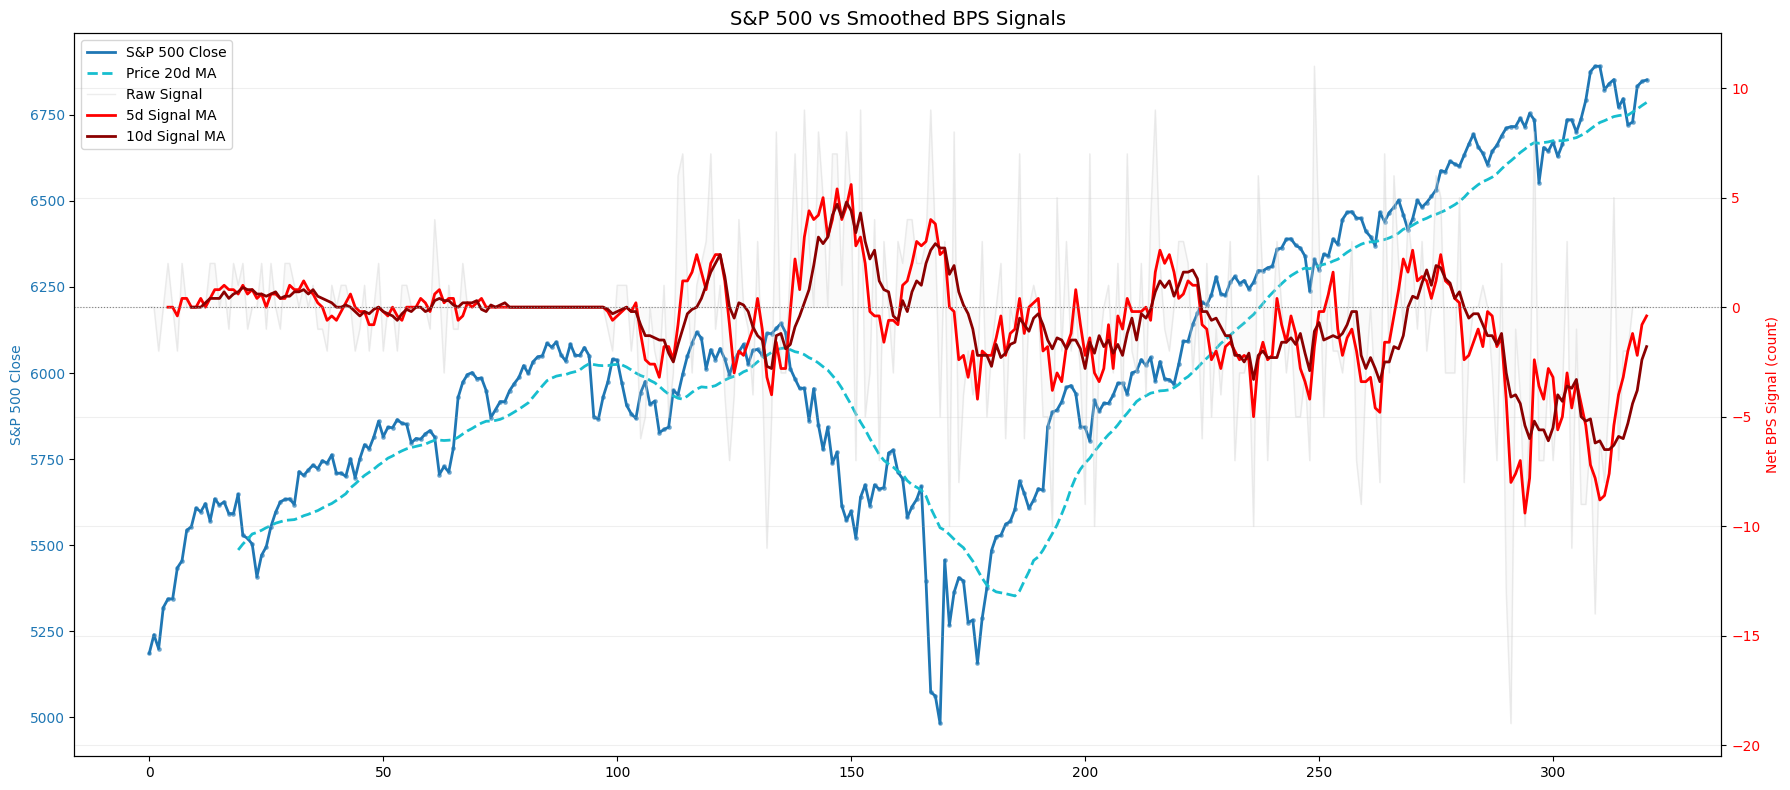

In [63]:
# Plot: S&P Close and smoothed BPS signals
import matplotlib.pyplot as plt


# Define MA periods
SHORT_MA = 5
LONG_MA = 10
assert LONG_MA > SHORT_MA, "Expect LONG_MA > SHORT_MA"

# Calculate moving averages for net_bps_signal (clean warm-up)
short_ma = merged_df['net_bps_signal'].rolling(SHORT_MA, min_periods=SHORT_MA).mean()
long_ma = merged_df['net_bps_signal'].rolling(LONG_MA, min_periods=LONG_MA).mean()

merged_df['net_bps_signal_ma_short'] = short_ma
merged_df['net_bps_signal_ma_long'] = long_ma
# State logic: short > long -> bearish, else -> bullish
gt = short_ma > long_ma
lt = short_ma < long_ma
state = pd.Series(index=merged_df.index, dtype='object')
state[gt] = 'bearish'
state[lt] = 'bullish'
# Ties remain NaN; carry forward previous state, then default to bullish
merged_df['market_state'] = state.ffill().fillna('bullish')
plt.figure(figsize=(18, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Left axis: S&P 500 Close
ax1.plot(
    merged_df.index,
    merged_df['Close'],
    color='tab:blue',
    linewidth=2,
    label='S&P 500 Close',
)
ax1.scatter(merged_df.index, merged_df['Close'], color='tab:blue', s=6, alpha=0.5)
ax1.plot(
    merged_df.index,
    merged_df['Close'].rolling(20).mean(),
    color='tab:cyan',
    linewidth=2,
    linestyle='--',
    label='Price 20d MA',
)
ax1.set_ylabel('S&P 500 Close', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis: net_bps_signal and its MAs
ax2.plot(
    merged_df.index,
    merged_df['net_bps_signal'],
    color='lightgray',
    linewidth=1,
    alpha=0.4,
    label='Raw Signal',
)
ax2.plot(
    merged_df.index,
    merged_df['net_bps_signal_ma_short'],
    color='red',
    linewidth=2,
    label=f'{SHORT_MA}d Signal MA',
)
ax2.plot(
    merged_df.index,
    merged_df['net_bps_signal_ma_long'],
    color='darkred',
    linewidth=2,
    label=f'{LONG_MA}d Signal MA',
)
ax2.fill_between(
    merged_df.index, merged_df['net_bps_signal'], color='lightgray', alpha=0.1
)
ax2.axhline(0, color='gray', linewidth=0.8, linestyle=':')
ax2.set_ylabel('Net BPS Signal (count)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('S&P 500 vs Smoothed BPS Signals', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [64]:
df = merged_df.copy()
df

,Date,Open,High,Low,Close,Volume,Daily_Return,Log_Return,High_Low_Range,Open_Close_Range,...,How_many_Fed_rate_cuts_in_2026_8_200_bps_delta,How_many_Fed_rate_cuts_in_2026_9_225_bps_delta,num_positive_bps_signals,num_negative_bps_signals,net_bps_signal,num_increase_cols_rising,num_decrease_cols_falling,net_bps_signal_ma_short,net_bps_signal_ma_long,market_state
0,2024-08-05,5151.140137,5250.890137,5119.259766,5186.330078,5333250000,-0.029969,-0.030427,0.025380,0.006785,...,NaN,NaN,0,0,0,0,0,NaN,NaN,bullish
1,2024-08-06,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,0.010354,0.010301,0.022668,0.006414,...,0.0000,0.0000,0,0,0,0,0,NaN,NaN,bullish
2,2024-08-07,5293.129883,5330.640137,5195.540039,5199.500000,4558260000,-0.007735,-0.007765,0.025983,0.018007,...,0.0000,0.0000,1,3,-2,1,2,NaN,NaN,bullish
3,2024-08-08,5252.569824,5328.029785,5233.850098,5319.310059,4016830000,0.023043,0.022781,0.017705,0.012547,...,0.0000,0.0000,2,2,0,1,1,NaN,NaN,bullish
4,2024-08-09,5314.660156,5358.669922,5300.839844,5344.160156,3516400000,0.004672,0.004661,0.010821,0.005520,...,0.0000,0.0000,2,0,2,0,0,0.0,NaN,bullish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2025-11-06,6787.589844,6796.680176,6707.509766,6720.319824,6051900000,-0.011178,-0.011241,0.013269,0.010010,...,0.0025,0.0015,11,13,-2,2,11,-2.0,-5.3,bearish
317,2025-11-07,6696.180176,6730.109863,6631.439941,6728.799805,5926070000,0.001262,0.001261,0.014664,0.004848,...,NaN,NaN,0,0,0,0,0,-1.2,-4.4,bearish
318,2025-11-10,6785.359863,6841.319824,6770.560059,6832.430176,5366050000,0.015401,0.015284,0.010356,0.006889,...,NaN,NaN,0,0,0,0,0,-2.2,-3.8,bearish
319,2025-11-11,6815.640137,6855.129883,6806.870117,6846.609863,4983490000,0.002075,0.002073,0.007049,0.004523,...,NaN,NaN,0,0,0,0,0,-0.8,-2.4,bearish


In [65]:
# %%writefile ../skfin/mv_estimators.py
import numpy as np
import pandas as pd
from skfin.metrics import sharpe_ratio
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

from dataclasses import dataclass, field
from typing import Callable, Optional


def compute_batch_holdings(pred, V, A=None, risk_target=None):
    """
    compute markowitz holdings with return prediction "mu" and covariance matrix "V"

    Args:
        pred: (numpy.ndarray or pandas.Series or pandas.DataFrame): Expected returns, can be of shape (N,) or (N, K).
        V: (numpy.ndarray): Covariance matrix of shape (N, N).
        A: (numpy.ndarray, optional): Matrix for linear constraints, default is None
        past_h (numpy.ndarray, optional): Not used in the current implementation.
        constant_risk (bool, optional): If True, normalize outputs to maintain constant risk, default is False.

    Returns:
        numpy.ndarray: Computed holdings.
    """

    N, _ = V.shape
    if isinstance(pred, (pd.Series, pd.DataFrame)):
        pred = pred.values
    if pred.ndim == 1:
        pred = pred[:, np.newaxis]
    elif pred.shape[1] == N:
        pred = pred.T
    print(V)
    V = V + 1e-6 * np.eye(V.shape[0])
    invV = np.linalg.inv(V)
    if A is None:
        M = invV
    else:
        U = invV.dot(A)
        if A.ndim == 1:
            M = invV - np.outer(U, U.T) / U.dot(A)
        else:
            M = invV - U.dot(np.linalg.inv(U.T.dot(A)).dot(U.T))
    h = M.dot(pred)
    if risk_target is not None:
        h = risk_target * h / np.sqrt(np.diag(h.T.dot(V.dot(h))))
    return h.T


@dataclass
class MeanVariance(BaseEstimator):
    """
    A mean-variance optimization estimator that computes portfolio holdings
    based on expected returns and the covariance matrix.

    Attributes:
        transform_V (Callable): Function to transform target variable 'y' into a covariance matrix.
        A (Optional[np.ndarray]): Constraints matrix for the optimization problem.
        risk_target (float): Risk target for the portfolio.
    """

    transform_V: Callable = field(default=lambda x: np.cov(x.T))
    A: Optional[np.ndarray] = None
    risk_target: float = 1.0

    def __post_init__(self):
        """
        Post-initialization process to set additional attributes or setup.
        """
        self.holdings_kwargs = {'risk_target': self.risk_target}

    @staticmethod
    def compute_batch_holdings(pred, V, A, risk_target, **kwargs):
        """
        Compute portfolio holdings in a batch manner.

        Parameters:
            pred (np.ndarray): Predicted returns.
            V (np.ndarray): Covariance matrix.
            A (np.ndarray): Constraint matrix.
            risk_target (float): Target risk level.
            **kwargs: Additional keyword arguments.

        Returns:
            np.ndarray: Portfolio holdings.
        """
        return compute_batch_holdings(pred=pred, V=V, A=A, **kwargs)

    def fit(self, X, y=None):
        """
        Fit the model by calculating the covariance matrix 'V_' from targets 'y'.

        Parameters:
            X (np.ndarray): Input feature matrix.
            y (np.ndarray): Target variable matrix.
        """
        self.V_ = self.transform_V(y)

    def predict(self, X, **kwargs):
        """
        Predict portfolio holdings based on input features.

        Parameters:
            X (np.ndarray): Input feature matrix.
            **kwargs: Additional keyword arguments.

        Returns:
            np.ndarray: Predicted portfolio holdings.
        """
        A = self.A if self.A is not None else np.ones(X.shape[1])
        kwargs = {**kwargs, **self.holdings_kwargs}
        h = self.compute_batch_holdings(pred=X, V=self.V_, A=A, **kwargs)
        return h

    def score(self, X, y):
        """
        Calculate the performance score of the portfolio using Sharpe ratio.

        Parameters:
            X (np.ndarray): Predicted returns.
            y (np.ndarray): Actual returns.

        Returns:
            float: Sharpe ratio of the portfolio.
        """
        return sharpe_ratio(np.sum(X * y, axis=1))


class Mbj(TransformerMixin):
    """
    Computing unconstrained mean-variance weights with the Britten-Jones (1999) trick.
    """

    def __init__(self, positive=False):
        self.positive = positive

    def fit(self, X, y=None):
        m = LinearRegression(fit_intercept=False, positive=self.positive)
        m.fit(X, y=np.ones(len(X)))
        self.coef_ = m.coef_ / np.sqrt(np.sum(m.coef_**2))
        return self

    def transform(self, X):
        return X.dot(self.coef_)


class TimingMeanVariance(BaseEstimator):
    def __init__(self, transform_V=None, a_min=None, a_max=None):
        if transform_V is None:
            self.transform_V = lambda x: np.var(x)
        else:
            self.transform_V = transform_V
        self.a_min = a_min
        self.a_max = a_max

    def fit(self, X, y=None):
        self.V_ = self.transform_V(y)

    def predict(self, X):
        if (self.a_min is None) & (self.a_max is None):
            h = X / self.V_
        else:
            h = np.clip(
                X / np.sqrt(self.V_), a_min=self.a_min, a_max=self.a_max
            ) / np.sqrt(self.V_)
        return h

In [66]:
# %%writefile ../skfin/backtesting.py
from dataclasses import dataclass

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# from skfin.mv_estimators import MeanVariance
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.metaestimators import _safe_split


def compute_pnl(h, ret, pred_lag):
    pnl = h.shift(pred_lag).mul(ret)
    if isinstance(h, pd.DataFrame):
        pnl = pnl.sum(axis=1)
    return pnl


def fit_predict(estimator, X, y, train, test, return_estimator=True):
    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)
    estimator.fit(X_train, y_train)
    if return_estimator:
        return estimator.predict(X_test), estimator
    else:
        return estimator.predict(X_test)


@dataclass
class Backtester:
    estimator: BaseEstimator = field(default_factory=MeanVariance)
    max_train_size: int = 36
    test_size: int = 1
    pred_lag: int = 1
    start_date: str = "2024-08-09"
    end_date: str = "2025-11-12"
    name: str = None

    def compute_holdings(self, X, y, pre_dispatch="2*n_jobs", n_jobs=1):
        X = X.loc[: self.end_date]
        cv = TimeSeriesSplit(
            max_train_size=self.max_train_size,
            test_size=self.test_size,
            n_splits=1 + len(X.loc[self.start_date :]) // self.test_size,
        )
        print(n_jobs)
        print(pre_dispatch)
        parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch)
        print(parallel)
        res = parallel(
            delayed(fit_predict)(
                clone(self.estimator), X.values, y.values, train, test, True
            )
            for train, test in cv.split(X)
        )
        y_pred, estimators = zip(*res)
        idx = X.index[np.concatenate([test for _, test in cv.split(X)])]
        if isinstance(y, pd.DataFrame):
            cols = y.columns
            h = pd.DataFrame(np.concatenate(y_pred), index=idx, columns=cols)
        elif isinstance(y, pd.Series):
            h = pd.Series(np.concatenate(y_pred), index=idx)
        else:
            h = None
        self.h_ = h
        self.estimators_ = estimators
        self.cv_ = cv
        return self

    def compute_pnl(self, ret):
        pnl = compute_pnl(self.h_, ret, self.pred_lag)
        self.pnl_ = pnl.loc[self.start_date : self.end_date]
        if self.name:
            self.pnl_ = self.pnl_.rename(self.name)
        return self

    def train(self, X, y, ret):
        self.compute_holdings(X, y)
        self.compute_pnl(ret)
        return self.pnl_

In [67]:
start_date = "2024-08-05"
test_size = 1
params = dict(max_train_size=36, test_size=test_size, gap=0)
params["n_splits"] = 1 + len(df.loc[start_date:]) // test_size
print(params)
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(**params)
cv

{'max_train_size': 36, 'test_size': 1, 'gap': 0, 'n_splits': 119}


TimeSeriesSplit(gap=0, max_train_size=36, n_splits=119, test_size=1)

In [68]:
df2 = df.drop(["market_state"], axis=1)  # [["Date", "Daily_Return"]]
df2 = df2.set_index('Date')
df2

,Open,High,Low,Close,Volume,Daily_Return,Log_Return,High_Low_Range,Open_Close_Range,Volume_MA_20,...,How_many_Fed_rate_cuts_in_2026_7_175_bps_delta,How_many_Fed_rate_cuts_in_2026_8_200_bps_delta,How_many_Fed_rate_cuts_in_2026_9_225_bps_delta,num_positive_bps_signals,num_negative_bps_signals,net_bps_signal,num_increase_cols_rising,num_decrease_cols_falling,net_bps_signal_ma_short,net_bps_signal_ma_long
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-05,5151.140137,5250.890137,5119.259766,5186.330078,5333250000,-0.029969,-0.030427,0.025380,0.006785,3.995839e+09,...,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN
2024-08-06,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,0.010354,0.010301,0.022668,0.006414,4.068702e+09,...,0.0,0.0000,0.0000,0,0,0,0,0,NaN,NaN
2024-08-07,5293.129883,5330.640137,5195.540039,5199.500000,4558260000,-0.007735,-0.007765,0.025983,0.018007,4.129810e+09,...,0.0,0.0000,0.0000,1,3,-2,1,2,NaN,NaN
2024-08-08,5252.569824,5328.029785,5233.850098,5319.310059,4016830000,0.023043,0.022781,0.017705,0.012547,4.129604e+09,...,0.0,0.0000,0.0000,2,2,0,1,1,NaN,NaN
2024-08-09,5314.660156,5358.669922,5300.839844,5344.160156,3516400000,0.004672,0.004661,0.010821,0.005520,4.120410e+09,...,0.0,0.0000,0.0000,2,0,2,0,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,6787.589844,6796.680176,6707.509766,6720.319824,6051900000,-0.011178,-0.011241,0.013269,0.010010,5.718622e+09,...,0.0,0.0025,0.0015,11,13,-2,2,11,-2.0,-5.3
2025-11-07,6696.180176,6730.109863,6631.439941,6728.799805,5926070000,0.001262,0.001261,0.014664,0.004848,5.685095e+09,...,NaN,NaN,NaN,0,0,0,0,0,-1.2,-4.4
2025-11-10,6785.359863,6841.319824,6770.560059,6832.430176,5366050000,0.015401,0.015284,0.010356,0.006889,5.688200e+09,...,NaN,NaN,NaN,0,0,0,0,0,-2.2,-3.8


In [69]:
for train, test in cv.split(df2):
    break
df2.iloc[train].index[-1].strftime("%Y%m%d"), df2.iloc[test].index[0].strftime("%Y%m%d")
# df.iloc[train]["Date"].apply(lambda r: r.strftime("%Y%m%d")), df.iloc[test][
#     "Date"
# ].apply(lambda r: r.strftime("%Y%m%d"))

('20250523', '20250527')

In [70]:
df2.dtypes

Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                         int64
                              ...   
net_bps_signal                 int64
num_increase_cols_rising       int64
num_decrease_cols_falling      int64
net_bps_signal_ma_short      float64
net_bps_signal_ma_long       float64
Length: 199, dtype: object

In [ ]:
from skfin.estimators import MLPRegressor, MultiLGBMRegressor, Ridge


def transform_X(df, window=12):
    return df.rolling(window=window).mean()


def transform_y(df):
    return df.shift(-1)


df2 = df2.fillna(0)
df3 = df2.drop(
    [
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Log_Return",
        "High_Low_Range",
        "Open_Close_Range",
    ],
    axis=1,
)
features = transform_X(df3)
target = transform_y(df3)["Daily_Return"]

l = LGBMRegressor(min_child_samples=5, n_estimators=200)
l.fit(features, target)
l.predict(features[-1:])

In [72]:
features[-1:]

,Daily_Return,Volume_MA_20,Volume_Ratio,Price_MA_20,Price_MA_50,Volatility_20,Fed_Interest_Rates_November_2024_25_bps_decrease,Fed_Interest_Rates_November_2024_25_bps_increase,Fed_Interest_Rates_November_2024_50_bps_decrease,Fed_Interest_Rates_November_2024_75_bps_decrease,...,How_many_Fed_rate_cuts_in_2026_7_175_bps_delta,How_many_Fed_rate_cuts_in_2026_8_200_bps_delta,How_many_Fed_rate_cuts_in_2026_9_225_bps_delta,num_positive_bps_signals,num_negative_bps_signals,net_bps_signal,num_increase_cols_rising,num_decrease_cols_falling,net_bps_signal_ma_short,net_bps_signal_ma_long
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-12,-0.000268,5.641156e+09,1.031224,6749.469558,6655.235298,0.008687,0.635667,0.002,0.014,0.002,...,-0.000458,-0.00025,-0.000042,7.333333,10.5,-3.166667,1.0,9.5,-4.333333,-5.1


In [73]:
target

Date
2024-08-05    0.010354
2024-08-06   -0.007735
2024-08-07    0.023043
2024-08-08    0.004672
2024-08-09    0.000043
                ...   
2025-11-06    0.001262
2025-11-07    0.015401
2025-11-10    0.002075
2025-11-11    0.000630
2025-11-12         NaN
Name: Daily_Return, Length: 321, dtype: float64